In [1]:
import os
import os.path
import csv
import time
import PIL
import math
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from ImageNet import *
from CNN import *
from ResNet import *
from utils import *

In [2]:
# Initialize dataset related parameters
data_dir = './data'

workers = 1
batch_size = 64

######################## task 3.1 ##########################

max_epochs = 40
lr = 0.015 

########################    END   ##########################


gpu = torch.cuda.is_available()

if gpu:
    print('Training on GPU')
else:
    print('Training on CPU')

Training on GPU


In [3]:
transform1 = transforms.RandomApply([
    ######################## task 0.1 ##########################
    # 依照概率执行
    #transforms.RandomCrop(192, padding=64, padding_mode='reflect'),transforms.RandomResizedCrop(size=192, scale=(0.5, 0.5)),transforms.Pad(padding=(8, 16, 32, 64), fill=(255, 0, 0)
])
########################    END   ##########################

transform2 = transforms.ToTensor()

In [4]:
dataset = TinyImageNetDataset(data_dir+'/train', transform=transforms.Compose([transform1, transform2]))
labels = dataset.get_labels()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
idx_tr, idx_val = next(sss.split(labels, labels))

dataset_tr = torch.utils.data.Subset(dataset, idx_tr)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

dataloader_tr = torch.utils.data.DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Training Dataset Length: ' + str(len(dataset_tr)))
print('Validation Dataset Length: ' + str(len(dataset_val)))

class_to_idx = dataset.get_class_to_idx()
dataset_test = TinyImageNetTestDataset(data_dir+'/val', annot_filename = 'val_annotations.txt', class_to_idx = class_to_idx, transform=transform2)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Test Dataset Length: ' + str(len(dataset_test)))

Training Dataset Length: 90000
Validation Dataset Length: 10000
Test Dataset Length: 10000


In [5]:
model = CNN()
# model = ResNet()
model.apply(init_weights)
if gpu:
    model.cuda()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
# model.to(device)#用两块1060加速

######################## task 3.2 ##########################
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, verbose=True, min_lr=1e-5)
criterion = nn.CrossEntropyLoss()
########################    END   ##########################

model_filename = 'mymodel.pth'

In [6]:
def train(dataloader, model, optimizer, criterion):
    batch = 0
    loss = 0.0
    correct = 0.0

    model.train()    
    
    with tqdm(total=len(dataloader.dataset), desc='train', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()
            optimizer.zero_grad()        
            logits = model(X)
            cur_loss = criterion(logits, Y)
            cur_loss.backward()
            optimizer.step()
            loss += cur_loss.item()
            pred = logits.argmax(dim = 1)
            correct += pred.eq(Y).sum()
            
            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100
    
    return loss, accuracy

In [7]:
train(dataloader_tr, model, optimizer, criterion)

train: 90.0kB [00:52, 1.71kB/s]                                                                     


(0.08142940276993646, 2.4655555555555555)

In [7]:
def validate(dataloader, model, criterion):
    
    ######################## task 3.3 ##########################
    batch = 0
    loss = 0.0
    correct = 0.0

    with tqdm(total=len(dataloader.dataset), desc='validate', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader: 
            if gpu:
                X = X.cuda()
                Y = Y.cuda()
            logits = model(X)
            cur_loss = criterion(logits, Y)
            loss += cur_loss.item()
            pred = logits.argmax(dim = 1)
            correct += pred.eq(Y).sum()
            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100
    print(accuracy)
    ########################    END   ##########################
    
    return loss, accuracy

In [8]:
def test(model, dataloader):
    
    ######################## task 3.4 ##########################
    batch = 0
    loss = 0.0
    correct = 0.0  

    with tqdm(total=len(dataloader.dataset), desc='test', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()
            logits = model(X)
            cur_loss = criterion(logits, Y)
            loss += cur_loss.item()
            pred = logits.argmax(dim = 1)
            correct += pred.eq(Y).sum()
            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    ########################    END   ##########################
    
    return pred, loss, accuracy


In [9]:
def fit(dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch = 100, scheduler = None, filename = None, early_stop = True, patience = 10, resume = False):
    start_epoch = 0
    early_stop_counter = 0
    min_loss_val = 1e10    
    loss_tr_hist = []
    loss_val_hist = []
    accuracy_tr_hist = []
    accuracy_val_hist = []
    # 模型基础上继续训练
    if resume == True:
        if filename is None:
            print('Please Provide File Name to load model')
            return
        start_epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = load_model(filename, model, optimizer, scheduler, mode = 'train')
        
        
    for epoch in range(start_epoch+1, max_epoch + 1):
        t0 = time.time()
        print(epoch)

        loss_tr, accuracy_tr = train(dataloader_tr, model, optimizer, criterion)
        loss_tr_hist.append(loss_tr)
        accuracy_tr_hist.append(accuracy_tr)

        loss_val, accuracy_val = validate(dataloader_val, model, criterion)
        loss_val_hist.append(loss_val)
        accuracy_val_hist.append(accuracy_val)

        if scheduler is not None:
            scheduler.step(loss_val)

        ######################## task 3.5 ##########################
        if early_stop:
            if early_stop_counter <= patience:
                if min_loss_val > loss_val:
                    early_stop_counter = 0
                    min_loss_val = loss_val
                    weight = model.state_dict().copy()
                else:
                    early_stop_counter += 1
            else:
                model.load_state_dict(weight)
                break
        ########################    END   ##########################
        
    return loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist, early_stop_counter

In [10]:
loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist, early_stop_counter = fit(
            ######################## task 3.6 ##########################
dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch = 30, scheduler = scheduler, filename = None, early_stop = True, patience = 10, resume = False
            ########################    END   ##########################
)

1


train: 90.0kB [01:29, 1.01kB/s]                                                                     
validate: 10.0kB [00:05, 1.95kB/s]                                                                  


4.15
2


train: 90.0kB [01:30, 999B/s]                                                                       
validate: 10.0kB [00:05, 1.94kB/s]                                                                  


11.86
3


train: 90.0kB [01:30, 997B/s]                                                                       
validate: 10.0kB [00:05, 2.00kB/s]                                                                  


15.97
4


train: 90.0kB [01:30, 995B/s]                                                                       
validate: 10.0kB [00:04, 2.03kB/s]                                                                  


18.4
5


train: 90.0kB [01:30, 990B/s]                                                                       
validate: 10.0kB [00:05, 1.84kB/s]                                                                  


20.52
6


train: 90.0kB [01:30, 990B/s]                                                                       
validate: 10.0kB [00:05, 1.87kB/s]                                                                  


21.38
7


train: 90.0kB [01:31, 979B/s]                                                                       
validate: 10.0kB [00:05, 1.95kB/s]                                                                  


21.959999999999997
8


train: 90.0kB [01:31, 988B/s]                                                                       
validate: 10.0kB [00:05, 1.96kB/s]                                                                  


23.13
9


train: 90.0kB [01:31, 981B/s]                                                                       
validate: 10.0kB [00:05, 1.98kB/s]                                                                  


23.93
10


train: 90.0kB [01:31, 984B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


24.48
11


train: 90.0kB [01:31, 983B/s]                                                                       
validate: 10.0kB [00:05, 1.93kB/s]                                                                  


25.45
12


train: 90.0kB [01:31, 984B/s]                                                                       
validate: 10.0kB [00:05, 1.92kB/s]                                                                  


25.679999999999996
13


train: 90.0kB [01:31, 981B/s]                                                                       
validate: 10.0kB [00:05, 1.95kB/s]                                                                  


26.5
14


train: 90.0kB [01:31, 985B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


26.0
15


train: 90.0kB [01:32, 971B/s]                                                                       
validate: 10.0kB [00:05, 1.84kB/s]                                                                  


27.200000000000003
16


train: 90.0kB [01:32, 974B/s]                                                                       
validate: 10.0kB [00:05, 1.88kB/s]                                                                  


27.200000000000003
17


train: 90.0kB [01:32, 971B/s]                                                                       
validate: 10.0kB [00:05, 1.94kB/s]                                                                  


26.939999999999998
18


train: 90.0kB [01:32, 974B/s]                                                                       
validate: 10.0kB [00:05, 1.95kB/s]                                                                  


27.68
19


train: 90.0kB [01:32, 974B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


27.48
20


train: 90.0kB [01:32, 975B/s]                                                                       
validate: 10.0kB [00:05, 1.98kB/s]                                                                  


27.91
21


train: 90.0kB [01:31, 980B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


27.77
22


train: 90.0kB [01:31, 981B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


27.800000000000004
23


train: 90.0kB [01:32, 978B/s]                                                                       
validate: 10.0kB [00:05, 1.96kB/s]                                                                  


27.139999999999997
24


train: 90.0kB [01:32, 978B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


27.82
25


train: 90.0kB [01:32, 978B/s]                                                                       
validate: 10.0kB [00:05, 1.98kB/s]                                                                  


28.599999999999998
26


train: 90.0kB [01:31, 982B/s]                                                                       
validate: 10.0kB [00:05, 1.97kB/s]                                                                  


28.09
27


train: 90.0kB [01:31, 979B/s]                                                                       
validate: 10.0kB [00:05, 1.90kB/s]                                                                  


28.050000000000004
28


train: 90.0kB [01:32, 977B/s]                                                                       
validate: 10.0kB [00:05, 1.91kB/s]                                                                  


28.970000000000002
29


train: 90.0kB [01:31, 979B/s]                                                                       
validate: 10.0kB [00:05, 1.84kB/s]                                                                  


28.64
30


train: 90.0kB [01:32, 976B/s]                                                                       
validate: 10.0kB [00:05, 1.91kB/s]                                                                  

29.099999999999998


In [11]:
save_model(model_filename, model, optimizer, scheduler, epoch=max_epochs, 
           loss_tr_hist=loss_tr_hist, 
           loss_val_hist=loss_val_hist, 
           accuracy_tr_hist=accuracy_tr_hist,
           accuracy_val_hist=accuracy_val_hist, 
           early_stop_counter=early_stop_counter)

In [12]:
model = CNN()
# model = ResNet()
model = load_model(model_filename, model, mode = 'test')
if gpu:
    model.cuda()
pred, loss_test, accuracy_test = test(model, dataloader_test)
print('Test Loss: {0:7.4f}  |  Test Accuracy: {1:7.4f}'.format(loss_test, accuracy_test))

test: 10.0kB [00:04, 2.22kB/s]                                                                      

Test Loss:  0.0496  |  Test Accuracy: 28.6700


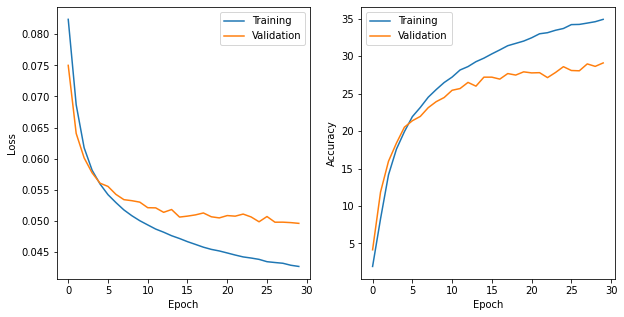

In [13]:
plot(loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist)